In [1]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [2]:
jtplot.style("gruvboxd")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [6]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [7]:
unique_chars = list(set(text))

In [8]:
len(unique_chars)

83

In [9]:
unique_chars

['0',
 'S',
 '_',
 'N',
 'z',
 '@',
 '$',
 'a',
 'y',
 'C',
 '-',
 '?',
 '/',
 'l',
 's',
 '5',
 'J',
 't',
 'R',
 'q',
 'B',
 '"',
 '3',
 'm',
 'x',
 'h',
 'K',
 'F',
 "'",
 ';',
 'c',
 'Q',
 'v',
 'D',
 'i',
 'w',
 'G',
 'u',
 'O',
 '9',
 'A',
 'P',
 '%',
 '!',
 'n',
 'k',
 'E',
 'M',
 'V',
 '&',
 '\n',
 'r',
 'b',
 'W',
 '1',
 'd',
 'X',
 'e',
 '(',
 'Z',
 'H',
 'Y',
 'L',
 'U',
 '4',
 'o',
 'I',
 '*',
 'f',
 '7',
 '2',
 'g',
 ')',
 'j',
 'p',
 '.',
 ',',
 'T',
 '6',
 '8',
 ' ',
 '`',
 ':']

In [10]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [11]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [12]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [13]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [14]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [15]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [16]:
batch_size = 32
seq_length = 16

In [17]:
numel_seq = batch_size * seq_length

In [18]:
numel_seq

512

In [19]:
encoded_text.shape[0]/numel_seq

3101.91015625

In [20]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [21]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [22]:
X, y = next(batch)

In [23]:
X

array([[ 9, 25,  7, 74, 17, 57, 51, 80, 54, 50, 50, 50, 60,  7, 74, 74],
       [57, 80, 25,  7, 55, 80, 68, 65, 51, 71, 65, 17, 17, 57, 44, 80],
       [17, 51,  7, 71, 57, 55,  8, 80, 34, 44, 50, 34, 17, 75, 21, 50],
       [17, 80, 25, 57, 51, 80, 35, 34, 17, 25, 80, 23, 57, 76, 80,  7],
       [57, 34, 51, 80, 25, 65, 14, 17, 50, 14, 23, 34, 13, 57, 55, 80],
       [57, 17, 57, 51, 14, 52, 37, 51, 71, 76, 80,  7, 14, 80, 14, 65],
       [14, 25, 57, 80, 35, 25, 34, 14, 74, 57, 51, 57, 55, 80, 74, 57],
       [68, 51, 65, 23, 80, 25, 57, 51, 80, 17, 65, 44, 57, 80, 17, 25],
       [68, 65, 51, 57, 75, 50, 50, 21, 60,  7, 32, 57, 80,  8, 65, 37],
       [35,  7, 14, 80, 30, 65, 23, 74, 13, 57, 17, 57, 13,  8, 80,  7],
       [57, 80, 40, 13, 57, 24, 57,  8, 80, 40, 13, 57, 24,  7, 44, 55],
       [25,  7, 55, 80, 68, 57, 13, 17, 80,  7, 17, 80, 34, 17, 75, 80],
       [74, 80, 17, 25, 57, 80, 13,  7, 14, 17, 80, 13, 34, 44, 57, 76],
       [ 8, 80, 35, 25, 34, 30, 25, 80, 30, 25, 34,

In [24]:
y

array([[25,  7, 74, 17, 57, 51, 80, 54, 50, 50, 50, 60,  7, 74, 74,  8],
       [80, 25,  7, 55, 80, 68, 65, 51, 71, 65, 17, 17, 57, 44, 80, 17],
       [51,  7, 71, 57, 55,  8, 80, 34, 44, 50, 34, 17, 75, 21, 50, 50],
       [80, 25, 57, 51, 80, 35, 34, 17, 25, 80, 23, 57, 76, 80,  7, 44],
       [34, 51, 80, 25, 65, 14, 17, 50, 14, 23, 34, 13, 57, 55, 80,  7],
       [17, 57, 51, 14, 52, 37, 51, 71, 76, 80,  7, 14, 80, 14, 65, 65],
       [25, 57, 80, 35, 25, 34, 14, 74, 57, 51, 57, 55, 80, 74, 57, 44],
       [51, 65, 23, 80, 25, 57, 51, 80, 17, 65, 44, 57, 80, 17, 25,  7],
       [65, 51, 57, 75, 50, 50, 21, 60,  7, 32, 57, 80,  8, 65, 37, 80],
       [ 7, 14, 80, 30, 65, 23, 74, 13, 57, 17, 57, 13,  8, 80,  7, 13],
       [80, 40, 13, 57, 24, 57,  8, 80, 40, 13, 57, 24,  7, 44, 55, 51],
       [ 7, 55, 80, 68, 57, 13, 17, 80,  7, 17, 80, 34, 17, 75, 80, 60],
       [80, 17, 25, 57, 80, 13,  7, 14, 17, 80, 13, 34, 44, 57, 76, 80],
       [80, 35, 25, 34, 30, 25, 80, 30, 25, 34, 13,

In [25]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [26]:
len(unique_chars)

83

In [27]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [28]:
X.shape

(32, 16)

In [29]:
X_.shape

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [30]:
print(help(nn.GRU))

Help on class GRU in module torch.nn.modules.rnn:

class GRU(RNNBase)
 |  GRU(*args, **kwargs)
 |  
 |  Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll}
 |          r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
 |          z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
 |          n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
 |          h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is the input
 |  at time `t`, :math:`h_{(t-1)}` is the hidden state of the layer
 |  at time `t-1` or the initial hidden state at time `0`, and :math:`r_t`,
 |  :math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
 |  :math:`\sigma` is the sigmoid function, and :math:`

In [31]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [32]:
len(text)

1588178

In [33]:
len(val_text)

397045

In [34]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [35]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [36]:
unique_char = encoding_results.unique_char
len(unique_char)

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [37]:
import torch
from torch import nn

class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [38]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 5
epochs = 30
lr = 1e-3

In [39]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.GRU,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [40]:
print(model)

CharRNN(
  (rnn): GRU(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [41]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [42]:
gc.collect()

0

In [43]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [44]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [45]:
### Num of train batches
print(num_batches)

124


In [46]:
### Num of valid batches
print(num_batches_)

31


In [47]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h]) if type(val_h) == tuple else val_h.data

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4815, Valid Loss: 3.1374

Epoch: 1/30, Iteration 40/124, Train Loss: 3.3032, Valid Loss: 3.0721

Epoch: 1/30, Iteration 60/124, Train Loss: 3.1997, Valid Loss: 2.8322

Epoch: 1/30, Iteration 80/124, Train Loss: 3.0745, Valid Loss: 2.5560

Epoch: 1/30, Iteration 100/124, Train Loss: 2.9583, Valid Loss: 2.4247

Epoch: 1/30, Iteration 120/124, Train Loss: 2.8650, Valid Loss: 2.3423

Epoch: 1/30, Iteration 124/124, Train Loss: 2.8484, Valid Loss: 2.3292


Epoch: 2/30, Iteration 20/124, Train Loss: 2.3131, Valid Loss: 2.2655

Epoch: 2/30, Iteration 40/124, Train Loss: 2.2794, Valid Loss: 2.2080

Epoch: 2/30, Iteration 60/124, Train Loss: 2.2511, Valid Loss: 2.1485

Epoch: 2/30, Iteration 80/124, Train Loss: 2.2228, Valid Loss: 2.0934

Epoch: 2/30, Iteration 100/124, Train Loss: 2.1966, Valid Loss: 2.0396

Epoch: 2/30, Iteration 120/124, Train Loss: 2.1700, Valid Loss: 1.9848

Epoch: 2/30, Iteration 124/124, Train Loss: 2.1644, Valid Loss: 1.9741


Epoch: 7/30, Iteration 80/124, Train Loss: 1.4805, Valid Loss: 1.4323

Epoch: 7/30, Iteration 100/124, Train Loss: 1.4784, Valid Loss: 1.4249

Epoch: 7/30, Iteration 120/124, Train Loss: 1.4741, Valid Loss: 1.4187

Epoch: 7/30, Iteration 124/124, Train Loss: 1.4730, Valid Loss: 1.4184


Epoch: 8/30, Iteration 20/124, Train Loss: 1.4552, Valid Loss: 1.4130

Epoch: 8/30, Iteration 40/124, Train Loss: 1.4434, Valid Loss: 1.4095

Epoch: 8/30, Iteration 60/124, Train Loss: 1.4413, Valid Loss: 1.4045

Epoch: 8/30, Iteration 80/124, Train Loss: 1.4405, Valid Loss: 1.4002

Epoch: 8/30, Iteration 100/124, Train Loss: 1.4391, Valid Loss: 1.3955

Epoch: 8/30, Iteration 120/124, Train Loss: 1.4355, Valid Loss: 1.3893

Epoch: 8/30, Iteration 124/124, Train Loss: 1.4345, Valid Loss: 1.3893


Epoch: 9/30, Iteration 20/124, Train Loss: 1.4200, Valid Loss: 1.3857

Epoch: 9/30, Iteration 40/124, Train Loss: 1.4095, Valid Loss: 1.3839

Epoch: 9/30, Iteration 60/124, Train Loss: 1.4084, Valid Loss: 1.380


Epoch: 13/30, Iteration 120/124, Train Loss: 1.3271, Valid Loss: 1.3136

Epoch: 13/30, Iteration 124/124, Train Loss: 1.3266, Valid Loss: 1.3145


Epoch: 14/30, Iteration 20/124, Train Loss: 1.3195, Valid Loss: 1.3117

Epoch: 14/30, Iteration 40/124, Train Loss: 1.3127, Valid Loss: 1.3129

Epoch: 14/30, Iteration 60/124, Train Loss: 1.3129, Valid Loss: 1.3116

Epoch: 14/30, Iteration 80/124, Train Loss: 1.3142, Valid Loss: 1.3102

Epoch: 14/30, Iteration 100/124, Train Loss: 1.3141, Valid Loss: 1.3068

Epoch: 14/30, Iteration 120/124, Train Loss: 1.3124, Valid Loss: 1.3058

Epoch: 14/30, Iteration 124/124, Train Loss: 1.3118, Valid Loss: 1.3075


Epoch: 15/30, Iteration 20/124, Train Loss: 1.3091, Valid Loss: 1.3067

Epoch: 15/30, Iteration 40/124, Train Loss: 1.3008, Valid Loss: 1.3061

Epoch: 15/30, Iteration 60/124, Train Loss: 1.3016, Valid Loss: 1.3056

Epoch: 15/30, Iteration 80/124, Train Loss: 1.3030, Valid Loss: 1.3030

Epoch: 15/30, Iteration 100/124, Train Loss: 1.3032, Val


Epoch: 20/30, Iteration 20/124, Train Loss: 1.2629, Valid Loss: 1.2802

Epoch: 20/30, Iteration 40/124, Train Loss: 1.2553, Valid Loss: 1.2820

Epoch: 20/30, Iteration 60/124, Train Loss: 1.2555, Valid Loss: 1.2817

Epoch: 20/30, Iteration 80/124, Train Loss: 1.2575, Valid Loss: 1.2784

Epoch: 20/30, Iteration 100/124, Train Loss: 1.2582, Valid Loss: 1.2771

Epoch: 20/30, Iteration 120/124, Train Loss: 1.2572, Valid Loss: 1.2773

Epoch: 20/30, Iteration 124/124, Train Loss: 1.2569, Valid Loss: 1.2769


Epoch: 21/30, Iteration 20/124, Train Loss: 1.2578, Valid Loss: 1.2757

Epoch: 21/30, Iteration 40/124, Train Loss: 1.2486, Valid Loss: 1.2766

Epoch: 21/30, Iteration 60/124, Train Loss: 1.2489, Valid Loss: 1.2765

Epoch: 21/30, Iteration 80/124, Train Loss: 1.2504, Valid Loss: 1.2763

Epoch: 21/30, Iteration 100/124, Train Loss: 1.2514, Valid Loss: 1.2741

Epoch: 21/30, Iteration 120/124, Train Loss: 1.2507, Valid Loss: 1.2747

Epoch: 21/30, Iteration 124/124, Train Loss: 1.2504, Vali


Epoch: 26/30, Iteration 60/124, Train Loss: 1.2204, Valid Loss: 1.2630

Epoch: 26/30, Iteration 80/124, Train Loss: 1.2222, Valid Loss: 1.2633

Epoch: 26/30, Iteration 100/124, Train Loss: 1.2230, Valid Loss: 1.2640

Epoch: 26/30, Iteration 120/124, Train Loss: 1.2221, Valid Loss: 1.2631

Epoch: 26/30, Iteration 124/124, Train Loss: 1.2218, Valid Loss: 1.2599


Epoch: 27/30, Iteration 20/124, Train Loss: 1.2220, Valid Loss: 1.2622

Epoch: 27/30, Iteration 40/124, Train Loss: 1.2152, Valid Loss: 1.2637

Epoch: 27/30, Iteration 60/124, Train Loss: 1.2160, Valid Loss: 1.2611

Epoch: 27/30, Iteration 80/124, Train Loss: 1.2180, Valid Loss: 1.2622

Epoch: 27/30, Iteration 100/124, Train Loss: 1.2191, Valid Loss: 1.2623

Epoch: 27/30, Iteration 120/124, Train Loss: 1.2185, Valid Loss: 1.2624

Epoch: 27/30, Iteration 124/124, Train Loss: 1.2181, Valid Loss: 1.2606


Epoch: 28/30, Iteration 20/124, Train Loss: 1.2185, Valid Loss: 1.2616

Epoch: 28/30, Iteration 40/124, Train Loss: 1.2103, Val

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


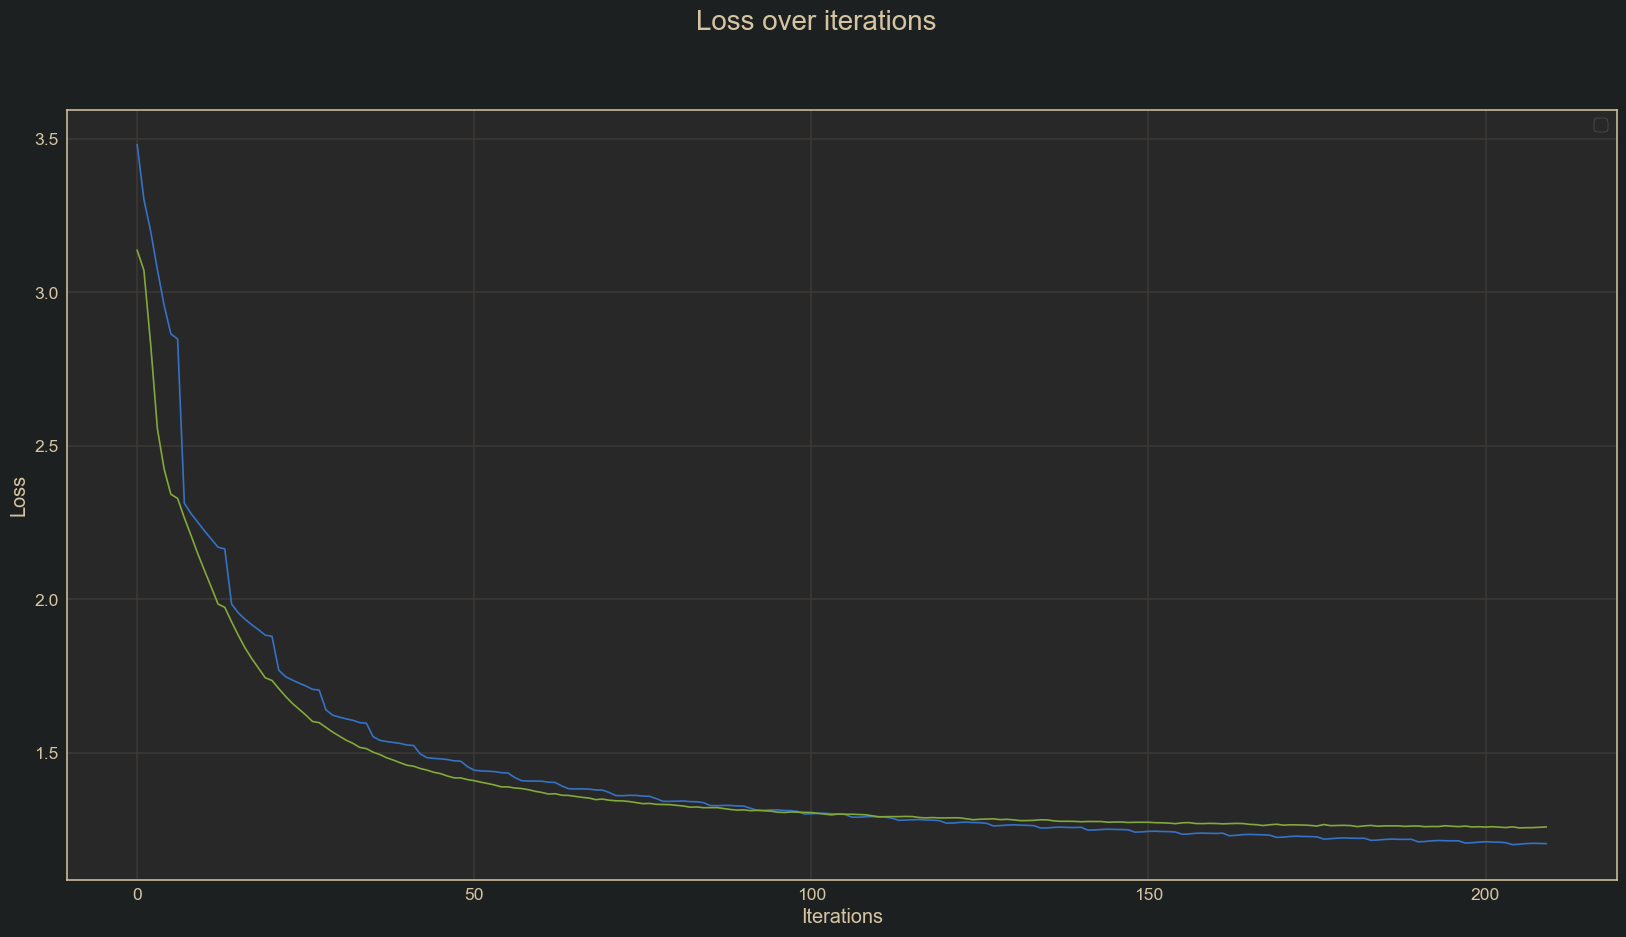

In [48]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, range(len(running_val_loss)), running_val_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [49]:
### Freeze model weights
model.requires_grad_ = False

In [50]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [51]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [52]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim=-1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [53]:
h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)
predict("D", h, model, 5)

(65,
 tensor([[[-0.2127,  0.0888,  0.0659,  ..., -0.1782, -0.0054,  0.1769]],
 
         [[ 0.2667,  0.2546,  0.0031,  ..., -0.0252,  0.2933,  0.3075]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward0>))

In [54]:
seed_list = list(seed)

h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)

for char in seed_list:
    h = h.data
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [55]:
print(''.join(seed_list))

Lan al'Mandragoran went up the mountain 


In [56]:
## Method 1
for ii in range(1000):
    h = h.data
    next_char, h = predict(seed_list_1[-1], h, model, k)
    seed_list_1.append(int2char[next_char])

In [57]:
## Method 2
for ix in range(1000):
    h = h.data
    x = np.array(char2int[seed_list_2[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    seed_list_2.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [58]:
pred_text = ''.join(seed_list_1)

In [59]:
print(pred_text)

Lan al'Mandragoran went up the mountain figure and dress as a few direction of their words and the sick man, and the marshal
fathers of a ball, started off, and there were.

"Nother with him? Which she does not show herself,
about them together and though, then."

"You must have let her
his man with him," said Seryozha, and
theried them his brother's father, as he was sitting down.

Stepan Arkadyevitch was at the bedication was
stilr, wartly back to her, he was asking what her face to his sing,
said that. She had a certain still before, he went on her and so that there was no one was
then. And that in the middle of his letter to her suppressed, and she was as he had not
been an answer. Although having done all the social form, and she had been stord with the peasants had
been comprehended, with a promite and heart, and saw what to be asticately dreased, and there an open face in his wife, he was all the
same time that there were the peasants, who, a conversation, and well to the positi

In [60]:
pred_text = ''.join(seed_list_2)

In [61]:
print(pred_text)

Lan al'Mandragoran went up the mountain standy carriages, who had told, though he had been daying the chous of his hands with which
they were coming intently at his face of the carriage.

"Oh, what do you think of anything and see him.
I am going to so much this it, as he could not say to the meaning of the cruating of that character in the moment a man of her to his back? There is a great difference in home? He wanted? And thinking about
him, it'll get him for this side to that
children, to be then."

"No; I don't learn
you,
and that's a lotgla detraig to say it, and I'll be
that the little country at one," said Levin.

She got up
at the
ball of the princess, having spent the thrief sound of talk and then,
which she saw
that the princess
said with a
friend of a spiritual process of her soul she
had been thought of him.

"Well, his consequence it's so likely is
an impression of a subject. This were your horse,
and that haven't the
solution."

"Oh the result of my side, then I have been